<h2 style="color:Blue; text-align: center; font-size: 30px"> 🏠💰 House Price Prediction💰 🏠
</h2> 

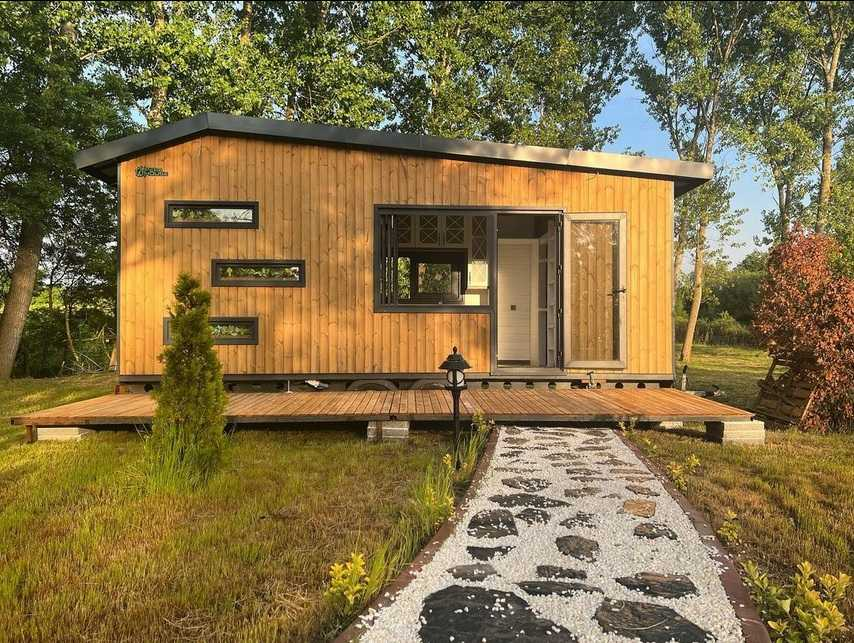

<h2 style="color:green; text-align: left; font-size: 20px"> Import Libraries
</h2>

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
#from helpers.data_prep import *
#from helpers.eda import *
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn import preprocessing

<h2 style="color:green; text-align: left; font-size: 20px"> Import Datasets & Data review
</h2>

In [2]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [3]:
def data_review(dataframe):
    print("**********head**********")
    print(dataframe.head())
    print("**********isna**********")
    print(dataframe.isnull().sum())
    print("**********shape*********")
    print(dataframe.shape)
    print("*********info***********")
    print(dataframe.info())
    print("*********describe*******")
    print(dataframe.describe().T)
    print("*********nuniq*******")
    print(dataframe.nunique())

data_review(df_train)

**********head**********
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePric

<h2 style="color:green; text-align: left; font-size: 20px"> Numeric and Categorical variables
</h2>

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """
      # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 1460
Variables: 81
cat_cols: 53
num_cols: 27
cat_but_car: 1
num_but_cat: 11


<h2 style="color:green; text-align: left; font-size: 20px"> Analysis of Categorical & Numerical Variables
</h2>

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df_train, col)

         MSZoning      Ratio
RL           1151  78.835616
RM            218  14.931507
FV             65   4.452055
RH             16   1.095890
C (all)        10   0.684932
      Street      Ratio
Pave    1454  99.589041
Grvl       6   0.410959
      Alley     Ratio
Grvl     50  3.424658
Pave     41  2.808219
     LotShape      Ratio
Reg       925  63.356164
IR1       484  33.150685
IR2        41   2.808219
IR3        10   0.684932
     LandContour      Ratio
Lvl         1311  89.794521
Bnk           63   4.315068
HLS           50   3.424658
Low           36   2.465753
        Utilities      Ratio
AllPub       1459  99.931507
NoSeWa          1   0.068493
         LotConfig      Ratio
Inside        1052  72.054795
Corner         263  18.013699
CulDSac         94   6.438356
FR2             47   3.219178
FR3              4   0.273973
     LandSlope      Ratio
Gtl       1382  94.657534
Mod         65   4.452055
Sev         13   0.890411
        Condition1      Ratio
Norm          1260  86

In [7]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df_train, col)

count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
5%         73.950000
10%       146.900000
20%       292.800000
30%       438.700000
40%       584.600000
50%       730.500000
60%       876.400000
70%      1022.300000
80%      1168.200000
90%      1314.100000
95%      1387.050000
99%      1445.410000
max      1460.000000
Name: Id, dtype: float64
#####################################
count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64
#####################################
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
5%         34.000000
10%        44.000000
20%        53.000000
30%  

<h2 style="color:green; text-align: left; font-size: 20px"> Dependent Variable Analysis According to Target Variable
</h2>

In [8]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df_train,"SalePrice",col)

            TARGET_MEAN
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275


          TARGET_MEAN
Street               
Grvl    130190.500000
Pave    181130.538514


         TARGET_MEAN
Alley               
Grvl   122219.080000
Pave   168000.585366


            TARGET_MEAN
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378


               TARGET_MEAN
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758


            TARGET_MEAN
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000


             TARGET_MEAN
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529


             TARGET_MEAN
LandSlope               
Gtl        179956.7

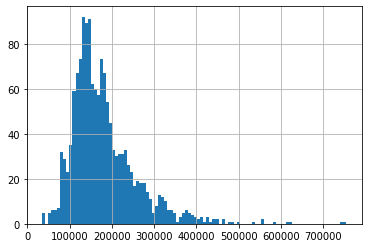

In [9]:
df_train["SalePrice"].hist(bins=100)
plt.show()

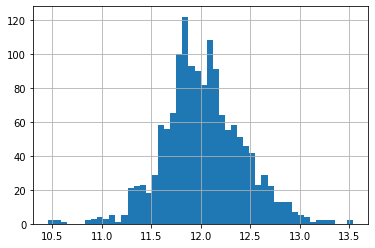

In [10]:
np.log1p(df_train['SalePrice']).hist(bins=50)
plt.show()

<h2 style="color:green; text-align: left; font-size: 20px"> Correlation Analysis
</h2>

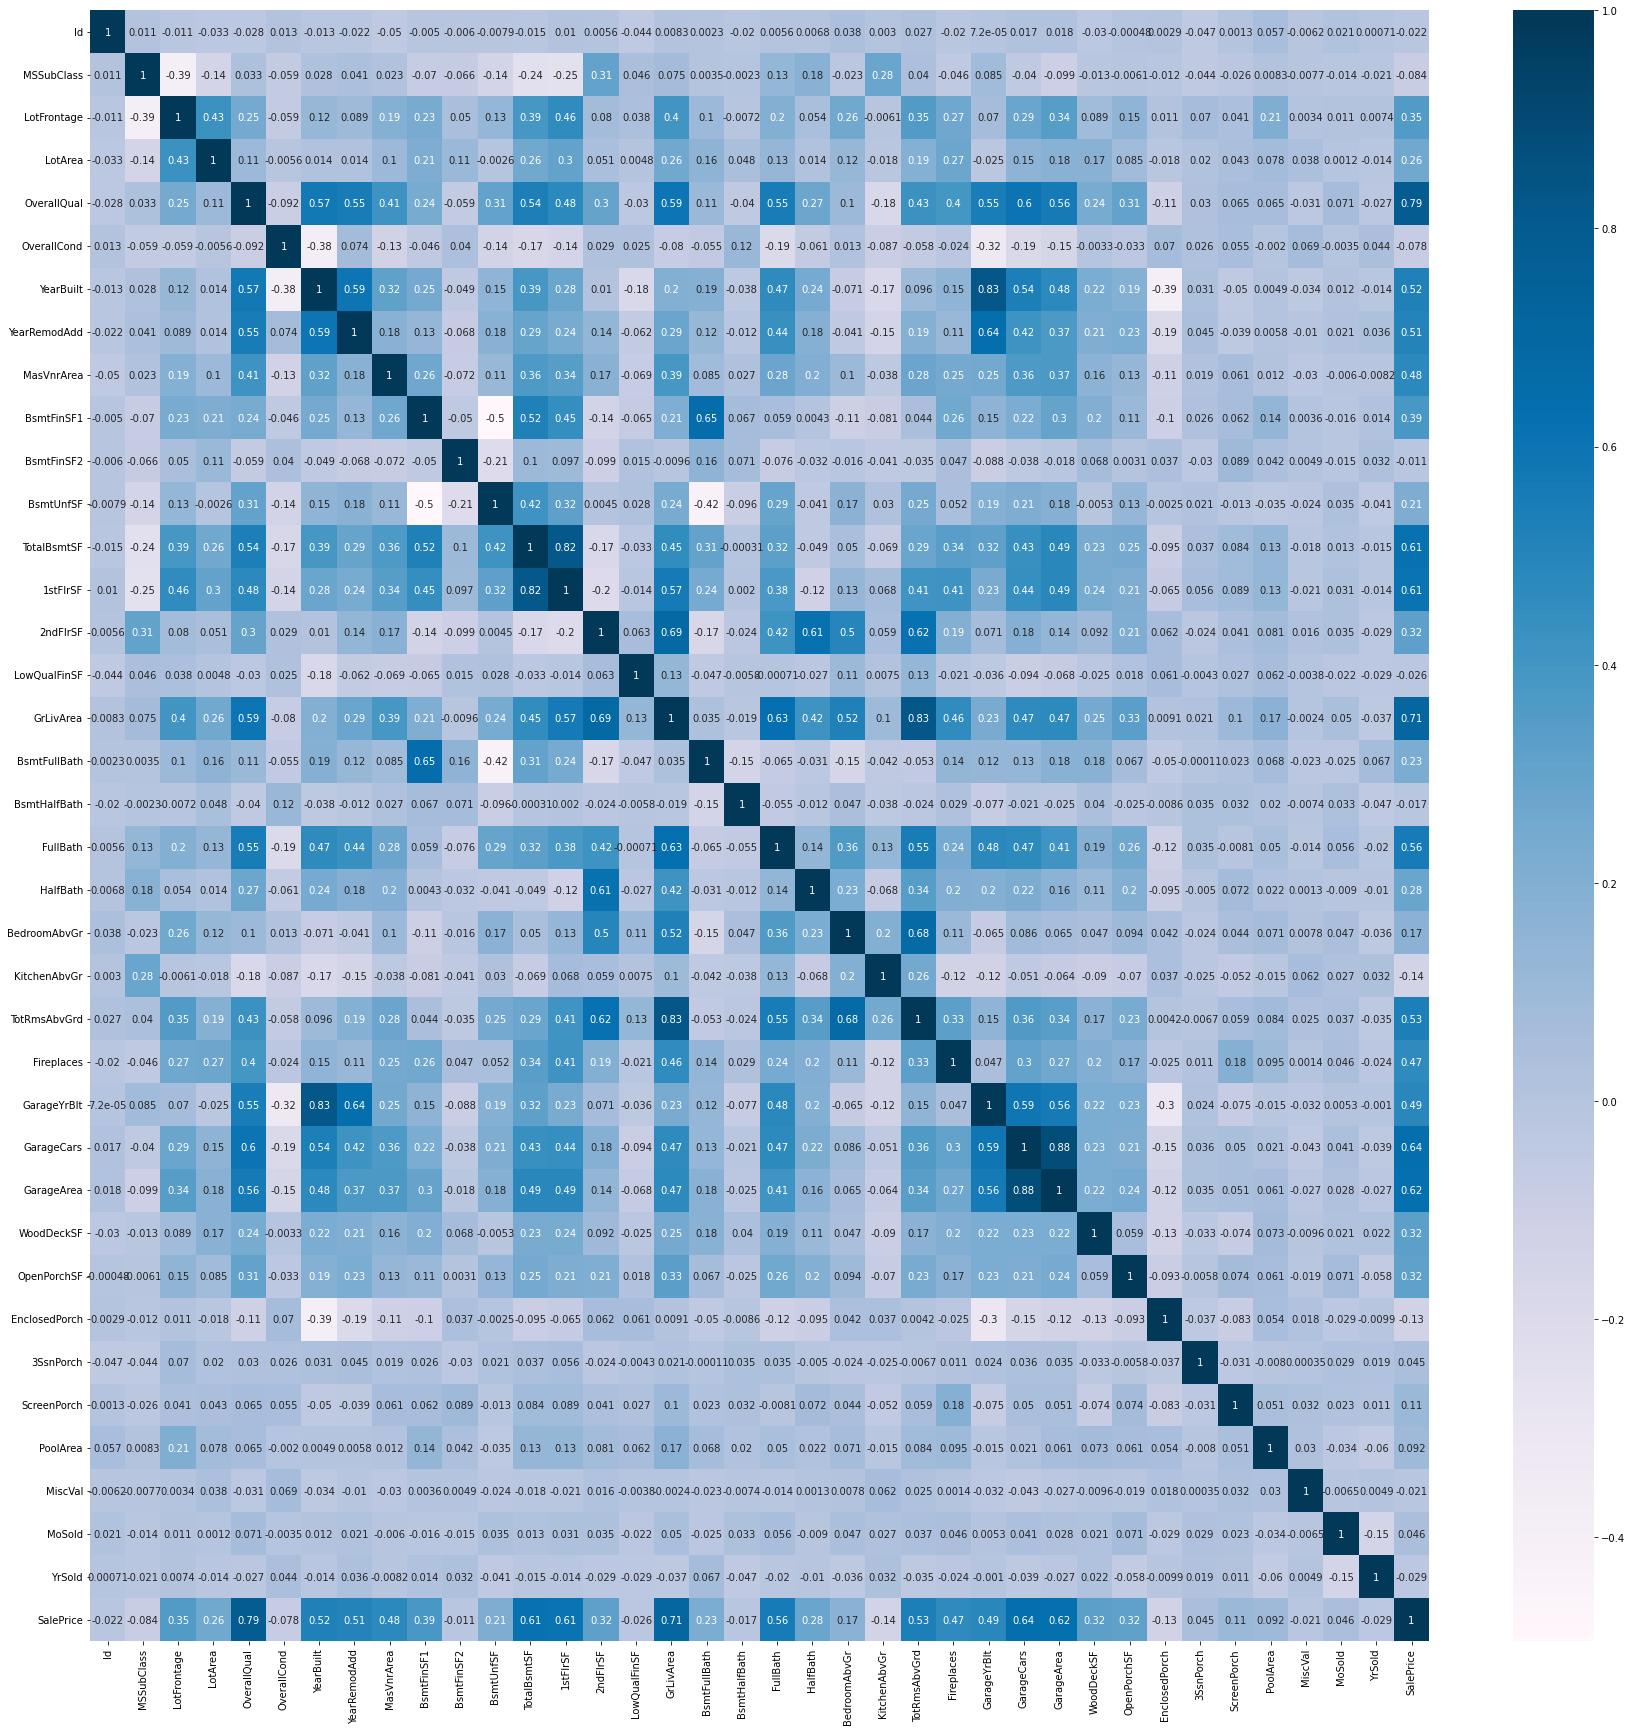

In [11]:
plt.figure(figsize=(30,30))  
p=sns.heatmap(df_train.corr(), annot=True,cmap =plt.cm.PuBu)

In [12]:
corr = df_train[num_cols].corr()
corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,...,0.000072,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,-0.006242,0.021172,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,0.085072,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,-0.007683,-0.013585,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.070250,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.003368,0.011200,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,0.014228,0.013788,0.104160,0.214103,0.111170,...,-0.024947,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.038068,0.001205,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.547766,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,-0.031406,0.070815,0.790982
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.825667,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,-0.034383,0.012398,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.642277,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,-0.010286,0.021490,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.252691,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,-0.029815,-0.005965,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.153484,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.003571,-0.015727,0.386420
BsmtFinSF2,-0.005968,-0.065649,0.049900,0.111170,-0.059119,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,-0.088011,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.004940,-0.015211,-0.011378


In [13]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


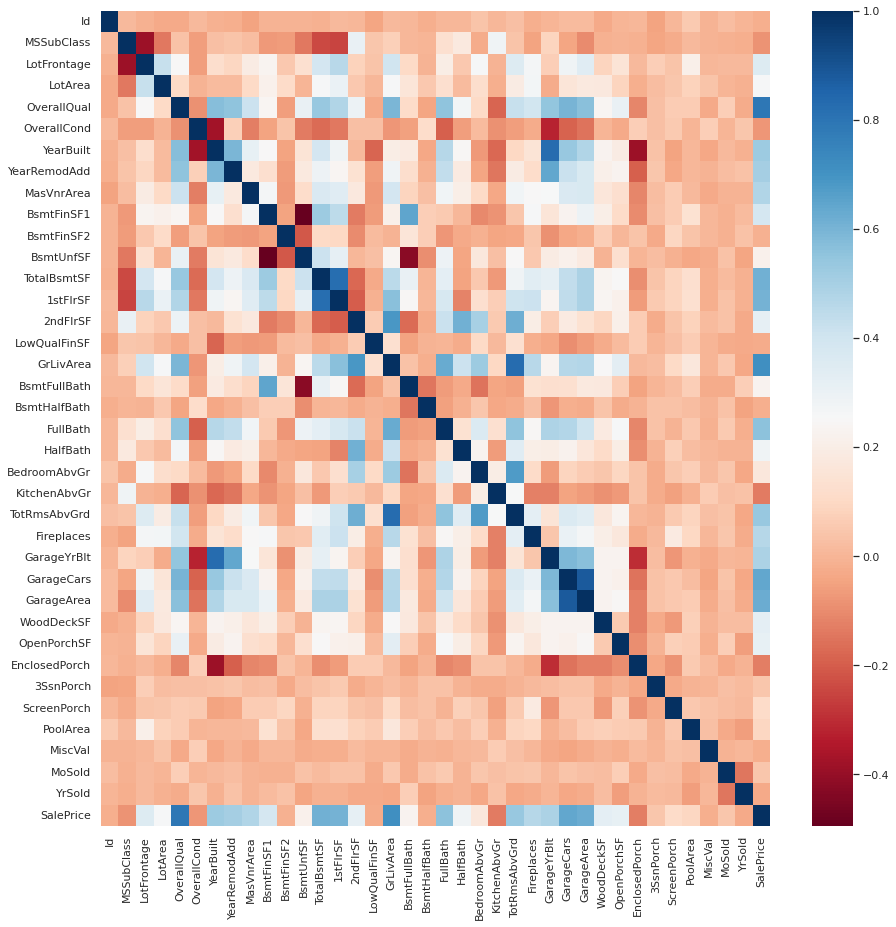

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice']

In [14]:
high_correlated_cols(df_train, plot=True)

<h2 style="color:green; text-align: left; font-size: 20px"> Outlier Analysis and Solution
</h2>

In [15]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [16]:
for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df_train, col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
MiscVal True
MoSold False


In [17]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [18]:
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df_train,col)

<h2 style="color:green; text-align: left; font-size: 20px"> Missing Values
</h2>

In [19]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [20]:
missing_values_table(df_train)

              n_miss  ratio
PoolQC          1453  99.52
MiscFeature     1406  96.30
Alley           1369  93.77
Fence           1179  80.75
FireplaceQu      690  47.26
LotFrontage      259  17.74
GarageType        81   5.55
GarageYrBlt       81   5.55
GarageFinish      81   5.55
GarageQual        81   5.55
GarageCond        81   5.55
BsmtExposure      38   2.60
BsmtFinType2      38   2.60
BsmtFinType1      37   2.53
BsmtCond          37   2.53
BsmtQual          37   2.53
MasVnrArea         8   0.55
MasVnrType         8   0.55
Electrical         1   0.07


In [21]:
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

In [22]:
for col in no_cols:
    df_train[col].fillna("No",inplace=True)


In [23]:
missing_values_table(df_train)

             n_miss  ratio
LotFrontage     259  17.74
GarageYrBlt      81   5.55
MasVnrType        8   0.55
MasVnrArea        8   0.55
Electrical        1   0.07


In [24]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if
                         data[col].isnull().sum() > 0]  

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  

    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x,
                      axis=0)

    
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


In [25]:
df_train = quick_missing_imp(df_train, num_method="median", cat_length=17)

# BEFORE
LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

LotFrontage    0
MasVnrType     0
MasVnrArea     0
Electrical     0
GarageYrBlt    0
dtype: int64 




<h2 style="color:green; text-align: left; font-size: 20px"> Categorical Distribution Analysis
</h2>

In [26]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [27]:
rare_analyser(df_train, "SalePrice", cat_cols)

MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     10  0.006849   74528.000000
FV          65  0.044521  214014.061538
RH          16  0.010959  131558.375000
RL        1151  0.788356  191004.994787
RM         218  0.149315  126316.830275


Street : 2
      COUNT    RATIO    TARGET_MEAN
Grvl      6  0.00411  130190.500000
Pave   1454  0.99589  181130.538514


Alley : 3
      COUNT     RATIO    TARGET_MEAN
Grvl     50  0.034247  122219.080000
No     1369  0.937671  183452.131483
Pave     41  0.028082  168000.585366


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    484  0.331507  206101.665289
IR2     41  0.028082  239833.365854
IR3     10  0.006849  216036.500000
Reg    925  0.633562  164754.818378


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk     63  0.043151  143104.079365
HLS     50  0.034247  231533.940000
Low     36  0.024658  203661.111111
Lvl   1311  0.897945  180183.746758


Utilities : 2
        COUNT     RATIO   TARGET_MEAN
AllPub   1459  0.99

In [28]:
df_train["ExterCond"] = np.where(df_train.LotShape.isin(["Fa", "Po"]), "FaPo", df_train["ExterCond"])
df_train["ExterCond"] = np.where(df_train.LotShape.isin(["Ex", "Gd"]), "Ex", df_train["ExterCond"])
df_train["ExterCond"]

0       TA
1       TA
2       TA
3       TA
4       TA
        ..
1455    TA
1456    TA
1457    Gd
1458    TA
1459    TA
Name: ExterCond, Length: 1460, dtype: object

In [29]:
df_train["LotShape"] = np.where(df_train.LotShape.isin(["IR1", "IR2", "IR3"]), "IR", df_train["LotShape"])

In [30]:
df_train["GarageQual"] = np.where(df_train.GarageQual.isin(["Fa", "Po"]), "FaPo", df_train["GarageQual"])
df_train["GarageQual"] = np.where(df_train.GarageQual.isin(["Ex", "Gd"]), "ExGd", df_train["GarageQual"])
df_train["GarageQual"] = np.where(df_train.GarageQual.isin(["ExGd", "TA"]), "ExGd", df_train["GarageQual"])
df_train["GarageQual"]


0       ExGd
1       ExGd
2       ExGd
3       ExGd
4       ExGd
        ... 
1455    ExGd
1456    ExGd
1457    ExGd
1458    ExGd
1459    ExGd
Name: GarageQual, Length: 1460, dtype: object

In [31]:
df_train["BsmtFinType2"] = np.where(df_train.BsmtFinType2.isin(["GLQ", "ALQ"]), "RareExcellent", df_train["BsmtFinType2"])
df_train["BsmtFinType2"] = np.where(df_train.BsmtFinType2.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df_train["BsmtFinType2"])

In [32]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [33]:
rare_encoder(df_train,0.01)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60,RL,65.0,8450.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2.0,2008,WD,Normal,208500
1,2.0,20,RL,80.0,9600.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5.0,2007,WD,Normal,181500
2,3.0,60,RL,68.0,11250.0,Pave,No,IR,Lvl,AllPub,...,0,No,No,No,0,9.0,2008,WD,Normal,223500
3,4.0,70,RL,60.0,9550.0,Pave,No,IR,Lvl,AllPub,...,0,No,No,No,0,2.0,2006,WD,Abnorml,140000
4,5.0,60,RL,84.0,14260.0,Pave,No,IR,Lvl,AllPub,...,0,No,No,No,0,12.0,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60,RL,62.0,7917.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,8.0,2007,WD,Normal,175000
1456,1457.0,20,RL,85.0,13175.0,Pave,No,Reg,Lvl,AllPub,...,0,No,MnPrv,No,0,2.0,2010,WD,Normal,210000
1457,1458.0,70,RL,66.0,9042.0,Pave,No,Reg,Lvl,AllPub,...,0,No,GdPrv,Shed,0,5.0,2010,WD,Normal,266500
1458,1459.0,20,RL,68.0,9717.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,4.0,2010,WD,Normal,142125


<h2 style="color:green; text-align: left; font-size: 20px"> Creating New Variables
</h2>

In [34]:
df_train["NEW_1st*GrLiv"]=(df_train["1stFlrSF"]*df_train["GrLivArea"])

df_train["NEW_Garage*GrLiv"]=(df_train["GarageArea"]*df_train["GrLivArea"])

df_train["TotalQual"] = df_train[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum(axis = 1)

df_train["TotalGarageQual"] = df_train[["GarageQual", "GarageCond"]].sum(axis = 1)

df_train["Overall"] = df_train[["OverallQual", "OverallCond"]].sum(axis = 1)

df_train["Exter"] = df_train[["ExterQual", "ExterCond"]].sum(axis = 1)

df_train["Qual"] = df_train[["OverallQual", "ExterQual", "GarageQual", "Fence", "BsmtFinType1", "BsmtFinType2", "KitchenQual", "FireplaceQu"]].sum(axis = 1)

df_train["Cond"] = df_train[["OverallCond", "ExterCond", "GarageCond", "BsmtCond", "HeatingQC", "Functional"]].sum(axis = 1)

# Total Floor
df_train["NEW_TotalFlrSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]

# Total Finished Basement Area
df_train["NEW_TotalBsmtFin"] = df_train.BsmtFinSF1+df_train.BsmtFinSF2

# Porch Area
df_train["NEW_PorchArea"] = df_train.OpenPorchSF + df_train.EnclosedPorch + df_train.ScreenPorch + df_train["3SsnPorch"] + df_train.WoodDeckSF

# Total House Area
df_train["NEW_TotalHouseArea"] = df_train.NEW_TotalFlrSF + df_train.TotalBsmtSF

df_train["NEW_TotalSqFeet"] = df_train.GrLivArea + df_train.TotalBsmtSF

df_train["NEW_TotalFullBath"] = df_train.BsmtFullBath + df_train.FullBath
df_train["NEW_TotalHalfBath"] = df_train.BsmtHalfBath + df_train.HalfBath

df_train["NEW_TotalBath"] = df_train["NEW_TotalFullBath"] + (df_train["NEW_TotalHalfBath"]*0.5)

# Lot Ratio
df_train["NEW_LotRatio"] = df_train.GrLivArea / df_train.LotArea

df_train["NEW_RatioArea"] = df_train.NEW_TotalHouseArea / df_train.LotArea

df_train["NEW_GarageLotRatio"] = df_train.GarageArea / df_train.LotArea

# MasVnrArea
df_train["NEW_MasVnrRatio"] = df_train.MasVnrArea / df_train.NEW_TotalHouseArea

# Dif Area
df_train["NEW_DifArea"] = (df_train.LotArea - df_train["1stFlrSF"] - df_train.GarageArea - df_train.NEW_PorchArea - df_train.WoodDeckSF)

# LowQualFinSF
df_train["NEW_LowQualFinSFRatio"] = df_train.LowQualFinSF / df_train.NEW_TotalHouseArea

df_train["NEW_OverallGrade"] = df_train["OverallQual"] * df_train["OverallCond"]

# Overall kitchen score
df_train["NEW_KitchenScore"] = df_train["KitchenAbvGr"] * df_train["KitchenQual"]
# Overall fireplace score
df_train["NEW_FireplaceScore"] = df_train["Fireplaces"] * df_train["FireplaceQu"]


df_train["NEW_Restoration"] = df_train.YearRemodAdd - df_train.YearBuilt

df_train["NEW_HouseAge"] = df_train.YrSold - df_train.YearBuilt

df_train["NEW_RestorationAge"] = df_train.YrSold - df_train.YearRemodAdd

df_train["NEW_GarageAge"] = df_train.GarageYrBlt - df_train.YearBuilt

df_train["NEW_GarageRestorationAge"] = np.abs(df_train.GarageYrBlt - df_train.YearRemodAdd)

df_train["NEW_GarageSold"] = df_train.YrSold - df_train.GarageYrBlt



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [35]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

df_train.drop(drop_list, axis=1, inplace=True)

In [36]:
cat_cols,  num_cols, cat_but_car = grab_col_names(df_train)

Observations: 1460
Variables: 103
cat_cols: 57
num_cols: 46
cat_but_car: 0
num_but_cat: 19


<h2 style="color:green; text-align: left; font-size: 20px"> Encoding Operations
</h2>

In [37]:
def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [38]:
binary_cols = [col for col in df_train.columns if df_train[col].dtypes == "O"
               and len(df_train[col].unique()) == 2]

In [39]:
for col in binary_cols:
    label_encoder(df_train, col)

In [40]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [41]:
df_train = one_hot_encoder(df_train, cat_cols, drop_first=True)

In [42]:
df_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Cond_9,NEW_TotalFullBath_1,NEW_TotalFullBath_2,NEW_TotalFullBath_3,NEW_TotalFullBath_4,NEW_TotalFullBath_6,NEW_TotalHalfBath_1,NEW_TotalHalfBath_2,NEW_TotalHalfBath_3,NEW_TotalHalfBath_4
0,1.0,60,65.0,8450.0,7.0,2003.0,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,1,0,0,0
1,2.0,20,80.0,9600.0,6.0,1976.0,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,1,0,0,0
2,3.0,60,68.0,11250.0,7.0,2001.0,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,1,0,0,0
3,4.0,70,60.0,9550.0,7.0,1915.0,1970,0.0,216.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,5.0,60,84.0,14260.0,8.0,2000.0,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,1,0,0,0


<h2 style="color:green; text-align: left; font-size: 20px">Model Building
</h2>

In [43]:
y = df_train['SalePrice']
X = df_train.drop(["Id", "SalePrice"], axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)
print(f"The shape of X_train is --> {(X_train.shape)}")
print(f"The shape of X_test is  --> {(X_test.shape)}")
print(f"The shape of y_train is --> {(y_train.shape)}")
print(f"The shape of y_test is  --> {(y_test.shape)}")

The shape of X_train is --> (1168, 315)
The shape of X_test is  --> (292, 315)
The shape of y_train is --> (1168,)
The shape of y_test is  --> (292,)


In [45]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]

In [46]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 37474.0679 (LR) 
RMSE: 32677.4309 (Ridge) 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e+11, tolerance: 7.592e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e+11, tolerance: 7.288e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

RMSE: 37930.7522 (Lasso) 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.375e+11, tolerance: 7.592e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.531e+11, tolerance: 7.288e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

RMSE: 33388.3704 (ElasticNet) 
RMSE: 47463.3385 (KNN) 
RMSE: 39222.258 (CART) 
RMSE: 29105.8235 (RF) 
RMSE: 81072.8725 (SVR) 
RMSE: 26303.6724 (GBM) 
RMSE: 29873.8642 (XGBoost) 
RMSE: 28399.4586 (LightGBM) 


In [47]:
lgbm_model = LGBMRegressor(random_state=46)
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=5, scoring="neg_mean_squared_error")))

In [48]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]}

In [49]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [50]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

In [51]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

27688.727273616776

In [52]:
lgbm_tuned = LGBMRegressor(**lgbm_gs_best.best_params_).fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)

In [53]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    regressors = [('LR', LinearRegression()),
                   ("Ridge", Ridge()),
                   ("Lasso", Lasso()),
                   ("ElasticNet", ElasticNet()),
                   ('KNN', KNeighborsRegressor()),
                   ('CART', DecisionTreeRegressor()),
                   ('RF', RandomForestRegressor()),
                   ('SVR', SVR()),
                   ('GBM', GradientBoostingRegressor()),
                   ("XGBoost", XGBRegressor(objective='reg:squarederror')),
                   ("LightGBM", LGBMRegressor())
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, regressor in regressors:
        rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
        print(f"RMSE: {round(rmse, 4)} ({name}) ")

In [54]:
base_models(X, y, scoring="RMSE")

Base Models....
RMSE: 37474.0679 (LR) 
RMSE: 32677.4309 (Ridge) 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e+11, tolerance: 7.592e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e+11, tolerance: 7.288e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

RMSE: 37930.7522 (Lasso) 


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.375e+11, tolerance: 7.592e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.531e+11, tolerance: 7.288e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

RMSE: 33388.3704 (ElasticNet) 
RMSE: 47463.3385 (KNN) 
RMSE: 40214.7914 (CART) 
RMSE: 29406.6577 (RF) 
RMSE: 81072.8725 (SVR) 
RMSE: 25930.0236 (GBM) 
RMSE: 29873.8642 (XGBoost) 
RMSE: 28399.4586 (LightGBM) 
